In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

import scoring_utils, tuning_utils

In [26]:
df = pd.read_csv('../data/data_clean.csv')


In [27]:
# One-hot encode UrbanRural and include it
from sklearn.preprocessing import OneHotEncoder

OHE = OneHotEncoder(sparse_output=False,handle_unknown='ignore')

UR_encoded = OHE.fit_transform(df[['UrbanRural']])
UR_enc_df = pd.DataFrame(UR_encoded,columns = OHE.get_feature_names_out(['UrbanRural']))
df = pd.concat([df,UR_enc_df], axis=1)
df.drop(columns=['UrbanRural'], inplace=True)


In [28]:
# Look for and remove outliers

def remove_outliers(df:pd.DataFrame, c:str):
    z_scores = np.abs((df[c] - df[c].mean())/df[c].std())
    no_outliers = df[z_scores < 3]
    return no_outliers

#remove outliers from features

have_outliers = ['Term','NoEmp','CreateJob','RetainedJob','GrAppv','SBA_Appv']

for col in have_outliers:
    # print(f"\n\nCol: {col}")
    # print("\nBefore:")
    # for s in df[col].describe().to_string().split('\n'):
    #     print(f'\t{s}')
    df_filtered = remove_outliers(df,col)
    # print("\nAfter:")
    # for s in df[col].describe().to_string().split('\n'):
    #     print(f'\t{s}')


In [29]:
# Select Features (X) and Target (Y)
unneeded_features = ['City', 'State', 'Bank', 'ApprovalFY', 'NAICS_i', 'FranchiseCode']
target = 'Default'
features = [f for f in df.columns if f not in unneeded_features and f not in target]

X = df[features]
Y = df[target]

In [30]:
# Do a train-test split
X_train, X_tmp, y_train, y_tmp = train_test_split(X,Y,test_size=0.1,random_state=42)
X_cv, X_test, y_cv, y_test = train_test_split(X_tmp, y_tmp, test_size=.5)

In [31]:
# Apply logarithmic transform to selected columns
log_columns = ['Term', 'DisbursementGross', 'GrAppv', 'SBA_Appv']
for col in log_columns:
    df[col] = np.log1p(df[col])  # Using np.log1p to avoid log(0) issues

In [32]:
# Scale Features
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_scaled = pd.DataFrame(sc.fit_transform(X_train), columns=features)
X_cv_scaled = pd.DataFrame(sc.transform(X_cv), columns=features)
X_test_scaled = pd.DataFrame(sc.transform(X_test), columns=features)
X_scaled = pd.DataFrame(sc.transform(X), columns=features)

In [33]:
X_train_scaled.sample(20)

,Term,NoEmp,CreateJob,RetainedJob,RevLineCr,LowDoc,DisbursementGross,GrAppv,SBA_Appv,isNewBusiness,isFranchise,SBARatio,InterestRate,UrbanRural_0,UrbanRural_1,UrbanRural_2
64653,-0.878187,-0.101280,-0.035824,-0.028843,1.833170,-0.376000,0.772441,0.719506,0.211414,1.594184,-0.249048,-1.221452,-1.712915,-0.753907,0.960509,-0.364832
9554,1.622350,0.143061,-0.002330,-0.045561,-0.545503,-0.376000,0.681065,0.737074,1.106302,-0.627280,-0.249048,1.664949,0.741346,1.326423,-1.041114,-0.364832
39553,-0.650865,-0.142004,-0.035824,-0.045561,-0.545503,-0.376000,-0.614514,-0.594556,-0.570850,1.594184,-0.249048,0.510389,0.837323,1.326423,-1.041114,-0.364832
213396,-1.269685,-0.074131,-0.035824,-0.045561,-0.545503,2.659577,-0.420523,-0.397798,-0.339488,-0.627280,-0.249048,1.087669,0.878456,1.326423,-1.041114,-0.364832
135129,0.106873,-0.128429,-0.014890,-0.037202,-0.545503,-0.376000,0.888911,0.930318,0.844384,1.594184,-0.249048,0.221749,0.371151,1.326423,-1.041114,-0.364832
625784,-1.118137,-0.046982,-0.035824,-0.045561,-0.545503,2.659577,-0.531375,-0.510231,-0.487036,1.594184,-0.249048,0.510389,0.371151,1.326423,-1.041114,-0.364832
596742,-0.271996,0.034465,-0.035824,-0.045561,-0.545503,2.659577,-0.358169,-0.334554,-0.290597,1.594184,-0.249048,0.799029,-1.004515,-0.753907,0.960509,-0.364832
21046,2.380089,-0.019833,0.006044,0.038029,-0.545503,-0.376000,0.369294,0.403288,0.014975,-0.627280,-0.249048,-1.221452,-1.708344,-0.753907,0.960509,-0.364832
97923,-0.953960,-0.101280,-0.035824,-0.012125,-0.545503,-0.376000,-0.600657,-0.580501,-0.596168,1.594184,-0.249048,-1.221452,-0.405804,-0.753907,0.960509,-0.364832
74650,-0.650865,-0.128429,-0.027450,-0.037202,-0.545503,-0.376000,-0.590265,-0.569961,-0.589621,-0.627280,-0.249048,-1.221452,1.070409,-0.753907,0.960509,-0.364832


In [46]:
# initialize the  model
logit = LogisticRegression(
    verbose=2, 
    n_jobs=-1, 
    max_iter=500,
    class_weight='balanced'
).fit(X_train_scaled, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.43054D+05    |proj g|=  1.61266D+05

At iterate    1    f=  5.28876D+05    |proj g|=  9.84547D+04

At iterate    2    f=  4.65412D+05    |proj g|=  5.03722D+04


 This problem is unconstrained.



At iterate    3    f=  4.42184D+05    |proj g|=  5.95870D+04

At iterate    4    f=  4.30424D+05    |proj g|=  4.02699D+04

At iterate    5    f=  4.15322D+05    |proj g|=  1.42877D+04

At iterate    6    f=  4.11731D+05    |proj g|=  4.89936D+03

At iterate    7    f=  4.11615D+05    |proj g|=  7.84148D+03

At iterate    8    f=  4.11031D+05    |proj g|=  1.87868D+03

At iterate    9    f=  4.10997D+05    |proj g|=  1.79916D+03

At iterate   10    f=  4.10815D+05    |proj g|=  2.23140D+03

At iterate   11    f=  4.10571D+05    |proj g|=  3.50168D+03

At iterate   12    f=  4.10346D+05    |proj g|=  2.99408D+03

At iterate   13    f=  4.10159D+05    |proj g|=  1.72096D+03

At iterate   14    f=  4.10117D+05    |proj g|=  1.11493D+03

At iterate   15    f=  4.10074D+05    |proj g|=  1.05233D+03

At iterate   16    f=  4.10026D+05    |proj g|=  2.74299D+03

At iterate   17    f=  4.09947D+05    |proj g|=  1.93148D+03

At iterate   18    f=  4.09744D+05    |proj g|=  3.29416D+03

At iter

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.3s finished


In [47]:
coefficients = logit.coef_[0]
feature_names = X.columns

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

coef_df

,Feature,Coefficient
0,Term,-1.770303
1,NoEmp,-0.417773
2,CreateJob,0.673412
3,RetainedJob,-0.597752
4,RevLineCr,-0.063318
5,LowDoc,-0.330408
6,DisbursementGross,-0.362595
7,GrAppv,1.457837
8,SBA_Appv,-0.869416
9,isNewBusiness,0.021041


In [48]:
best_cutoff = tuning_utils.get_cutoff(logit, pd.DataFrame(X_scaled, columns=features), Y)

Cutoff: 0.4 , Profit: $3,593.67
Cutoff: 0.45 , Profit: $3,342.03
Cutoff: 0.5 , Profit: $3,086.08
Cutoff: 0.525 , Profit: $2,894.98
Cutoff: 0.55 , Profit: $2,731.29
Cutoff: 0.575 , Profit: $2,427.96
Cutoff: 0.6 , Profit: $2,378.67


In [49]:
yprob_train = logit.predict(X_train_scaled)
yprob_train

array([0, 0, 1, ..., 1, 0, 1])

In [50]:
yprob_df = pd.DataFrame(yprob_train, index=y_train.index)

In [51]:
test = pd.concat([yprob_df, y_train], axis=1)

In [52]:
test.sample(20)

,0,Default
544540,1,0
477864,0,0
274340,0,0
642554,0,0
175809,1,1
589150,0,0
780985,1,1
450368,0,0
552283,0,0
613243,1,0


In [53]:
yhat_train = np.mean(logit.predict(X_train_scaled))
yhat_train

0.3919079674572602

In [54]:
#make predictions
yhat_train = logit.predict(X_train_scaled)
yhat_cv = logit.predict(X_test_scaled)

score = pd.concat([
    scoring_utils.get_metrics(y_train, yhat_train, "Logit Train"),
    scoring_utils.get_metrics(y_test, yhat_cv, "Logit CV")
])

score

,Recall,Precision,ROC,F1
Logit Train,0.822459,0.360120,0.759869,0.500912
Logit CV,0.829481,0.355996,0.762205,0.498183


In [55]:
logit.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 500,
 'multi_class': 'auto',
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 2,
 'warm_start': False}

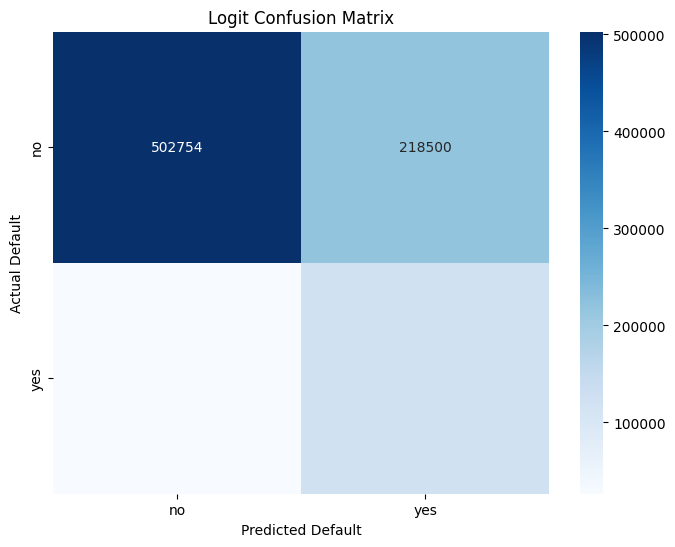

In [56]:
yhat_total = logit.predict(X_scaled)
scoring_utils.get_confusion_matrix(Y, yhat_total, "Logit")

In [45]:
scoring_utils.get_profit(X, Y, yhat_total)

5126351987.25